# Trabalho Final

## Imports

In [400]:
import itertools
import pandas as pd
import numpy as np
import random
from dataclasses import dataclass as dc
from typing import Iterable
from collections import namedtuple
from plotnine import *
from copy import deepcopy
pd.set_option('display.max_colwidth', None)

## Functions

In [401]:
Numero = int # Indice da tarefa
intervalo = namedtuple("intervalo", ["inicio", "fim"])
def first(iterable, func, default=None):
  return next(filter(func, iterable), default)
def first_ind(iterable, func, default=None):
  return next((i for i, x in enumerate(iterable) if func(x)), default)
seed = random.seed
@dc
class Tarefa:
  numero: int
  tempo: int
  def __repr__(self):
    return f"T{self.numero}({self.tempo})"
  def __hash__(self):
    return repr(self).__hash__()
class Tarefas:
  def __init__(self, tempos: list[int]):
    self.tarefas = [Tarefa(i+1, tempos[i]) for i in range(len(tempos))]
  
  def __getitem__(self, i: Numero | Iterable[Numero]):
    if isinstance(i, Iterable):
      return [self.tarefas[i-1] for i in i]
    return self.tarefas[i-1]
  def __iter__(self):
    return iter(self.tarefas)
  def smallest_to_highest(self):
    return sorted(self.tarefas, key=lambda t: t.tempo)

@dc 
class Maquina:
  numero: int
  n_tarefas: int
  tarefas: list[Tarefa] = None

  def __post_init__(self):
    assert self.tarefas is None or len(self.tarefas) <= self.n_tarefas
    if self.tarefas is None: self.tarefas = []
  def assignTarefas(self, tarefas: list[Tarefa]):
    assert len(tarefas) <= self.n_tarefas
    self.tarefas = tarefas
    return self
  def queueTarefa(self, tarefa: Tarefa):
    assert len(self.tarefas) < self.n_tarefas # se for igual ent n pode adicionar
    self.tarefas.append(tarefa)
    return self
  def reset(self):
    self.tarefas = []
    return self
  
  def quantoTempo(self):
    return sum(t.tempo for t in self.tarefas)
  def __repr__(self):
    return f"M{self.numero}({repr(self.tarefas)}, {self.quantoTempo()})"
  def __str__(self):
    return f"M{self.numero}"
  def isTarefaIn(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Tarefa):
      return tarefa in self.tarefas
    return tarefa in [t.numero for t in self.tarefas]
  def quandoComeca(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    # index of tarefa in self.tarefas
    ind = self.tarefas.index(tarefa)
    return sum(t.tempo for t in self.tarefas[:ind])
  def quandoAcaba(self, tarefa: Tarefa | Numero):
    if isinstance(tarefa, Numero):
      tarefa = first(self.tarefas, lambda t: t.numero == tarefa)
    return self.quandoComeca(tarefa) + tarefa.tempo

class Horario:
  # representa as maquians e as horas que as tarefas começam
  # horario comeca completo, vindo da Permutation.getHorario()
  # Horario.timeOf("M1") -> quando acaba a maquina 1
  # Horario["T1"] -> quando começa e acaba a tarefa 1
  # Horario.whereIs("T1") -> Em que máquina está a tarefa 1
  # nota: isto pode estar dentro do permutation, mas acho melhor assim para dividir funções
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
  def __getitem__(self, tarefa: str | Tarefa) -> intervalo:
    maq = self.whereIs(tarefa)
    if maq is None: raise KeyError(f"Tarefa {tarefa} não está no horário")
    return intervalo(maq.quandoComeca(tarefa), maq.quandoAcaba(tarefa))
  def timeOf(self, maquina: str | Maquina):
    if isinstance(maquina, str):
      maquina = self.getMaquina(maquina)
    return maquina.quantoTempo()
  def getMaquina(self, maquina: str | Numero):
    if isinstance(maquina, str): 
      return first(self.maquinas, lambda m: str(m) == maquina)
    return first(self.maquinas, lambda m: m.numero == maquina)
  def whereIs(self, tarefa: str | Tarefa):
    if isinstance(tarefa, str):
      tarefa = int(tarefa[1:])
    return first(self.maquinas, lambda m: m.isTarefaIn(tarefa))
  def getTempoTotal(self):
    return max(m.quantoTempo() for m in self.maquinas)
  @property
  def tempoTotal(self):
    return self.getTempoTotal()
  def plot(self):
    df = pd.DataFrame({
      "maquina": [m.numero for m in self.maquinas for t in m.tarefas ],
      "tarefa": [t.numero for m in self.maquinas  for t in m.tarefas ],
      "tarefaL": [f"T{t.numero}" for m in self.maquinas  for t in m.tarefas ],
      "comeca": [m.quandoComeca(t)  for m in self.maquinas for t in m.tarefas],
      "acaba": [m.quandoAcaba(t) for m in self.maquinas for t in m.tarefas]
    })
    return ggplot(df, aes(y = "maquina")) + \
      geom_point(aes(x = "comeca", color='factor(tarefa)'), size = 5) + \
      geom_path(aes(x = "acaba", group = "maquina", color="factor(tarefa+1)")) + \
      geom_path(aes(x = "comeca", group = "maquina", color="factor(tarefa)")) + \
      geom_vline(xintercept=self.tempoTotal, linetype="dashed") + \
      geom_text(aes(x = "comeca", label="tarefaL"), size=10, nudge_x=0.1, nudge_y=0.1) + \
      \
      scale_x_continuous(breaks=[0, 24, 48, 72, 96, 120, self.tempoTotal]) + \
      scale_y_continuous(breaks=[1, 2, 3]) + \
      scale_color_discrete(guide=False) + \
      coord_fixed(xlim = (-0.5, 144)) + \
      labs(x="horas", y="maquina") + \
      theme_classic() + \
      theme(aspect_ratio=0.7)
class Permutation:
  # Representação por permutação
  def __init__(self, maquinas: list[Maquina]):
    self.maquinas = maquinas
    self.n_maquinas = len(maquinas)
  def reset(self):
    self = deepcopy(self)
    for m in self.maquinas:
      m.reset()
    return self
  def machineYielder(self):
    for m in self.maquinas:
      for i in range(len(m.tarefas)):
        yield m
  def assignTarefas(self, tarefas: list[Tarefa]):
    self.reset()
    for m in self.machineYielder():
      m.queueTarefa(tarefas.pop(0))
    return self.as_list()
  def as_list(self) -> list[Tarefa]:
    return [t for m in self.maquinas for t in m.tarefas]
  def as_cromo(self) -> list[int]:
    return [t.numero for t in self.as_list()]
  def as_lists(self) -> list[list[Tarefa]]:
    return [m.tarefas for m in self.maquinas]
  def __repr__(self):
    return repr(self.as_lists())
  def getHorario(self) -> Horario:
    return Horario(self.maquinas)
  @property
  def horario(self) -> Horario:
    return self.getHorario()
  def __getitem__(self, index_or_maquina: int | str) -> Tarefa | Maquina:
    if isinstance(index_or_maquina, str): # Maquina
      return first(self.maquinas, lambda m: str(m) == index_or_maquina)
    return self.as_list()[index_or_maquina]
M1 = Maquina(
  numero = 1,
  n_tarefas = 4,
)
M2 = Maquina(
  numero = 2,
  n_tarefas = 3,
)
M3 = Maquina(
  numero = 3,
  n_tarefas = 3,
)
M1, M2, M3

(M1([], 0), M2([], 0), M3([], 0))

In [402]:
tarefas = Tarefas([38, 33, 36, 20, 32, 29, 46, 38, 34, 40])
tarefas[1,2,4]
def getTarefas(l: list[Numero]):
  return tarefas[l]

[[T1(38), T2(33), T3(36), T4(20)], [T5(32), T6(29), T7(46)], [T8(38), T9(34), T10(40)]]


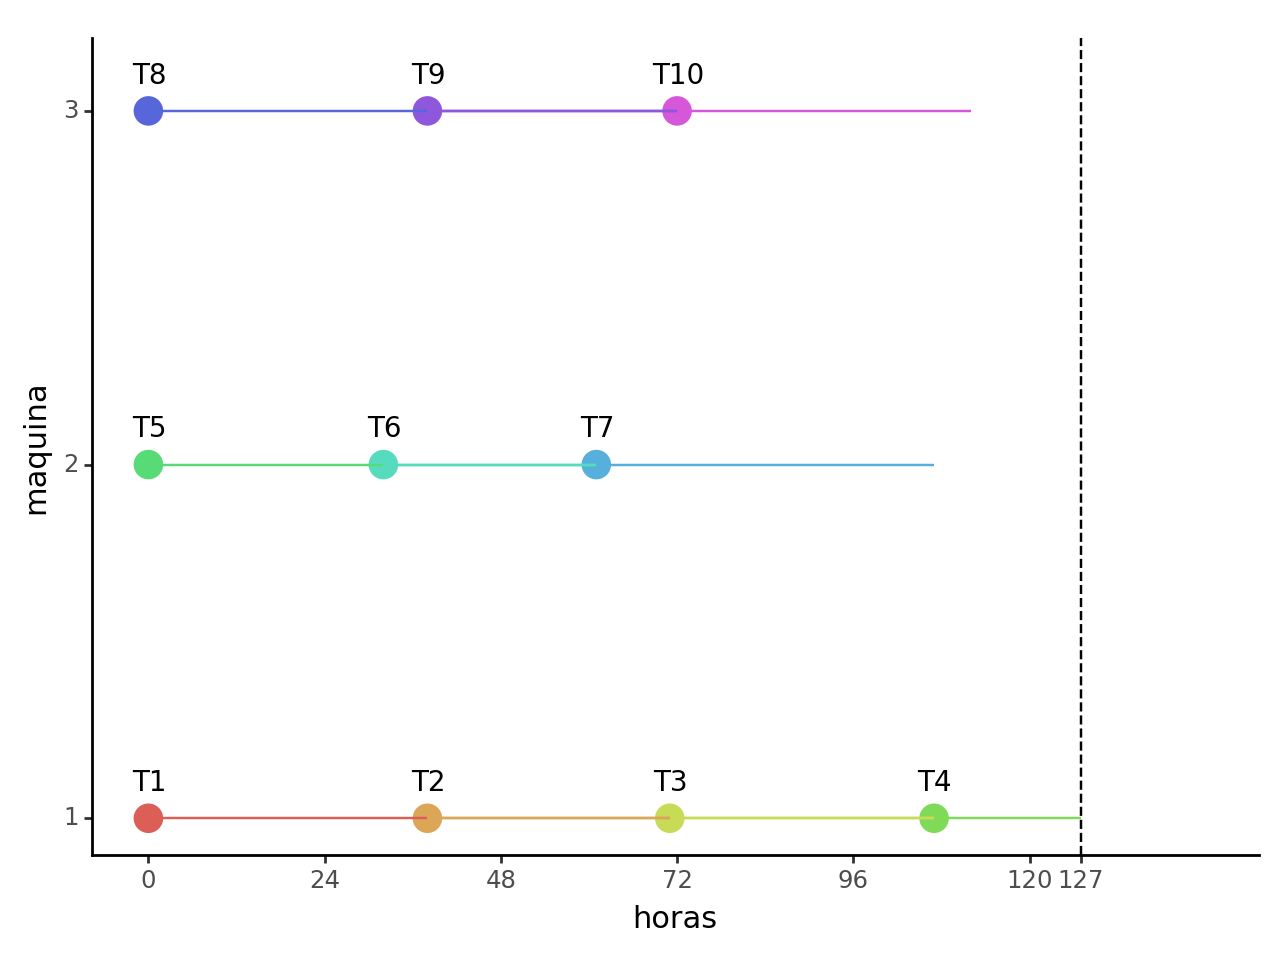

<Figure Size: (640 x 480)>

In [403]:
# exemplo
M1.assignTarefas(tarefas[1,2,3,4])
M2.assignTarefas(tarefas[5,6,7])
M3.assignTarefas(tarefas[8,9,10])
primeiro = primeira = Permutation([M1, M2, M3])
print(primeiro)
primeiro.horario.plot()

In [404]:
def respeitaRestricao(horario, maximos: dict[Tarefa, int]):
  for tarefa, maximo in maximos.items():
    if horario[tarefa].fim > maximo:
      return False
  return True
acabarAntes = 24*(5-1) # 1 junho (8h) até 5 junho (8h),
restricao = {
  tarefas[3]: acabarAntes,
  tarefas[4]: acabarAntes,
  tarefas[5]: acabarAntes
}
respeitaRestricao(primeiro.horario, restricao)

False

In [405]:
def create_df(permutations: list[Permutation] | Permutation, *args):
  if isinstance(permutations, Permutation): return create_df([permutations, *args])
  return pd.DataFrame({
    "M1": [p.maquinas[0].tarefas for p in permutations],
    "M2": [p.maquinas[1].tarefas for p in permutations],
    "M3": [p.maquinas[2].tarefas for p in permutations],
    "tempo_total": [p.horario.tempoTotal for p in permutations],
    "respeita_restricao": [respeitaRestricao(p.horario, restricao) for p in permutations],
    "respeita_unique": [len(set(p.as_cromo())) == len(p.as_cromo()) for p in permutations]
  })
# use example
create_df(primeiro)

,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T1(38), T2(33), T3(36), T4(20)]","[T5(32), T6(29), T7(46)]","[T8(38), T9(34), T10(40)]",127,False,True


## Pergunta a)

TODO palavras

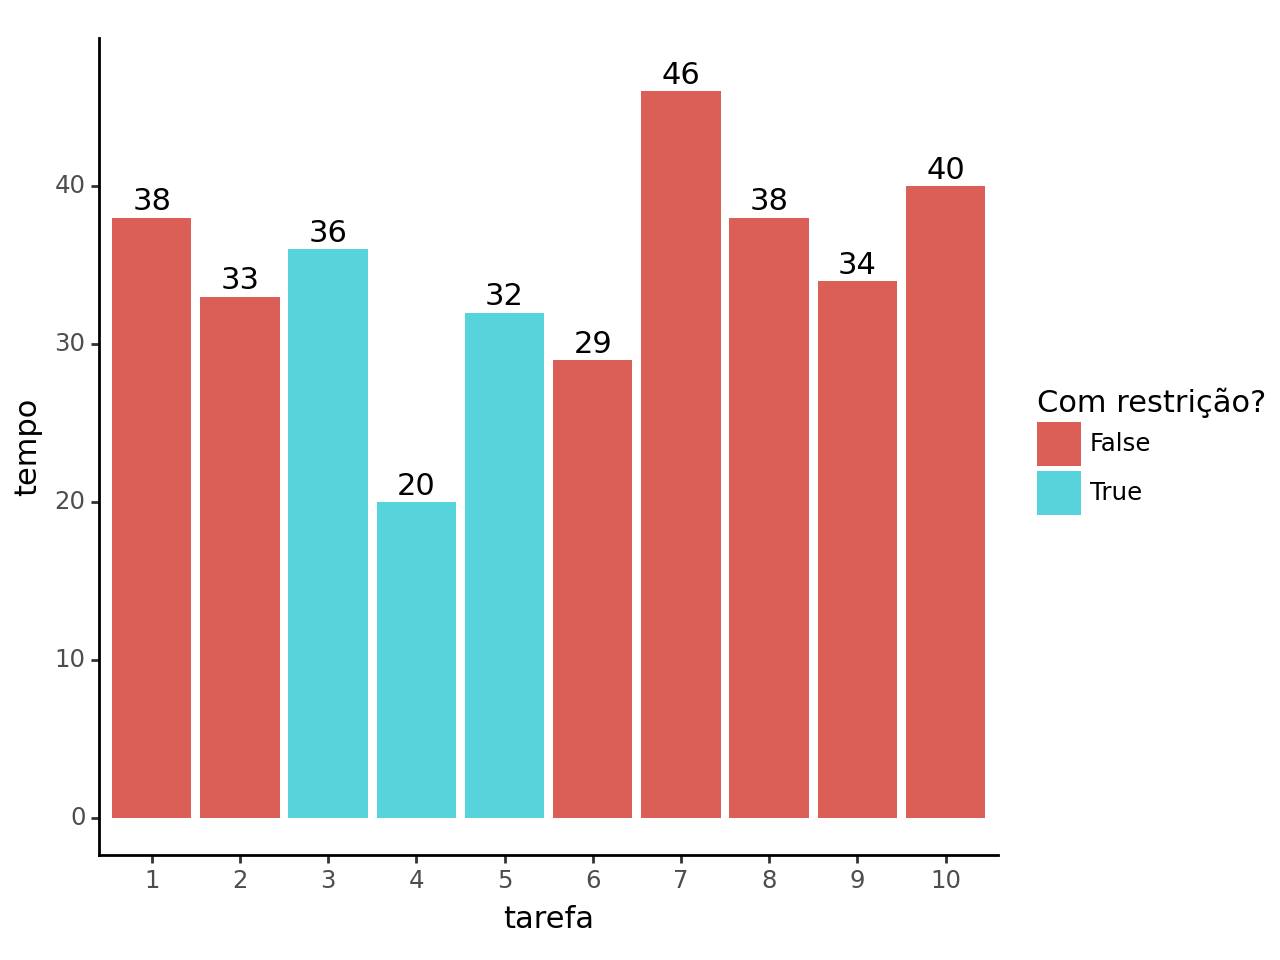

<Figure Size: (640 x 480)>

In [406]:
# bar plot with tarefas e o tempo delas (color the priority ones) 
ggplot(pd.DataFrame({
  "tarefa": [t.numero for t in tarefas],
  "tempo": [t.tempo for t in tarefas],
  "prioridade": [t in restricao for t in tarefas]
}), aes(x = "factor(tarefa)", y = "tempo")) + \
  geom_bar(aes(fill = "factor(prioridade)"), stat = "identity", position = "dodge") + \
  scale_fill_discrete(name = "Com restrição?") + \
  geom_text(aes(label="tempo"), nudge_y=1) + \
  labs(x="tarefa", y="tempo") + \
  theme_classic() 

## Pergunta b)

1.Iremos atribuir as 3 tarefas críticas (T3, T4, T5), a cada uma das máquinas, a fim de se conseguir realizar o prazo o mais rápido possivel

  1.1 Vamos dar a mais rápida destas à máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

2.De seguida, será colocado a tarefa mais rápida na máquina com mais tarefas (M1), pois esta precisa de fazer 4 tarefas

3.Por fim, as tarefas restantes serão distribuidas de forma a dar um equilibrio entre elas

  3.1 Para isso, iremos dar as duas mais pequenas seguintes à M1

  3.2 E por a mais pequena e maior das restantes na M2

  3.3 Por fim, as 2 tarefas restantes irão para a M3

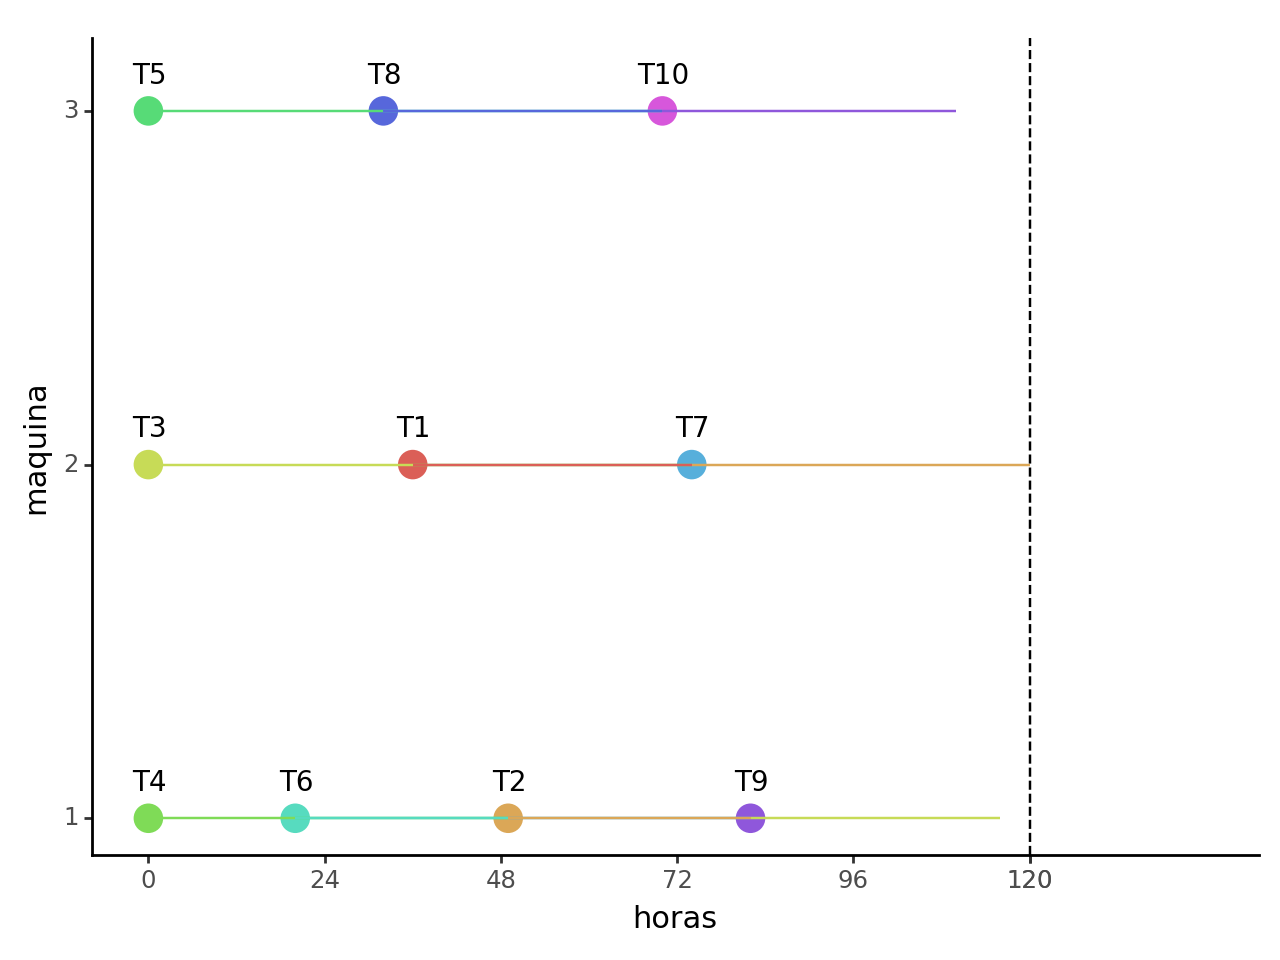

<Figure Size: (640 x 480)>

In [407]:
heuristica = primeiro.reset()
M1, M2, M3 = heuristica.maquinas
pool = tarefas.smallest_to_highest()
criticas = tarefas[3,4,5]
# 1.1
M1.queueTarefa(smallest_critical := min(criticas, key=lambda t: t.tempo))
pool.remove(smallest_critical)
criticas.remove(smallest_critical)
# 1.2
M2.queueTarefa(criticas[0])
M3.queueTarefa(criticas[1])
[pool.remove(t) for t in criticas]
# 2
M1.queueTarefa(pool.pop(0)) # pool esta ordenada
# 3.1
M1.queueTarefa(pool.pop(0))
M1.queueTarefa(pool.pop(0))
# 3.2
M2.queueTarefa(pool.pop(0))
M2.queueTarefa(pool.pop(-1))
# 4
M3.queueTarefa(pool.pop(0))
M3.queueTarefa(pool.pop(0))
heuristica.horario.plot()

In [408]:
create_df(heuristica)

,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T4(20), T6(29), T2(33), T9(34)]","[T3(36), T1(38), T7(46)]","[T5(32), T8(38), T10(40)]",120,True,True


É possível visualizar que a restrição foi respeitada

## Pergunta c)

In [409]:
heuristica.as_cromo()

[4, 6, 2, 9, 3, 1, 7, 5, 8, 10]

Nota:
- As 4 primeiras tarefas correspondem à máquina 1
- Da 5 à 7 tarefas correspondem à máquina 2
- As restantes tarefas correspondem à máquina 3

O cromossoma está representado por permutação

In [410]:
def fromCromo(cromo: list[int]) -> Permutation:
  M1, M2, M3 = Maquina(1, 4), Maquina(2, 3), Maquina(3, 3)
  return deepcopy(Permutation([
    M1.assignTarefas(tarefas[cromo[:4]]),
    M2.assignTarefas(tarefas[cromo[4:7]]),
    M3.assignTarefas(tarefas[cromo[7:]])
  ]))

## Pergunta d)

**Operador de crossover**

In [411]:
# ERO
def crossover(pai: list[int], mae:list[int], log = False) -> list[int]:
  # selecionar aleatoriamente uma ligacao entre 2 genes, entre os pais, e adicionar a um novo filho
  filho = []
  nao_escolhidos = set(pai)

  # 1º escolher um ponto de partida aleatorio
  ponto_partida = current = random.choice([pai[0], mae[0]])
  # 2º fazer as matrizes de adjacencia (incluindo os ultimos)
  pai_adj = {pai[i]: {pai[i-1], pai[(i+1)%len(pai)]} for i in range(len(pai))}
  mae_adj = {mae[i]: {mae[i-1], mae[(i+1)%len(mae)]} for i in range(len(mae))}
  # 3º fazer uniao das matrizes de adjacencia
  adj = {i: pai_adj[i] | mae_adj[i] for i in pai_adj}
  # 4º fazer o filho
  while len(nao_escolhidos) > 1:
    if log: print("Não escolhidos:", nao_escolhidos)
    if log: print("Filho:", filho)
    if log: print("Current:", current)
    # adicionar o current ao filho
    filho.append(current)
    nao_escolhidos.remove(current)

    # conseguir as escolhas possiveis
    escolhas = adj[current] & nao_escolhidos
    if len(escolhas) == 0:
      # se nao houver escolhas, escolher um aleatorio entre os nao escolhidos
      current = random.choice(list(nao_escolhidos))
    else:
      current = random.choice(list(escolhas))
  # adicionar o filho que falta
  filho.append(nao_escolhidos.pop())
  return filho
cruzamento = crossover# exemplo

seed(1)
filho = crossover(heuristica.as_cromo(), primeiro.as_cromo(), log=True)
filho

Não escolhidos: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Filho: []
Current: 4
Não escolhidos: {1, 2, 3, 5, 6, 7, 8, 9, 10}
Filho: [4]
Current: 10
Não escolhidos: {1, 2, 3, 5, 6, 7, 8, 9}
Filho: [4, 10]
Current: 9
Não escolhidos: {1, 2, 3, 5, 6, 7, 8}
Filho: [4, 10, 9]
Current: 8
Não escolhidos: {1, 2, 3, 5, 6, 7}
Filho: [4, 10, 9, 8]
Current: 7
Não escolhidos: {1, 2, 3, 5, 6}
Filho: [4, 10, 9, 8, 7]
Current: 5
Não escolhidos: {1, 2, 3, 6}
Filho: [4, 10, 9, 8, 7, 5]
Current: 6
Não escolhidos: {1, 2, 3}
Filho: [4, 10, 9, 8, 7, 5, 6]
Current: 2
Não escolhidos: {1, 3}
Filho: [4, 10, 9, 8, 7, 5, 6, 2]
Current: 1


[4, 10, 9, 8, 7, 5, 6, 2, 1, 3]

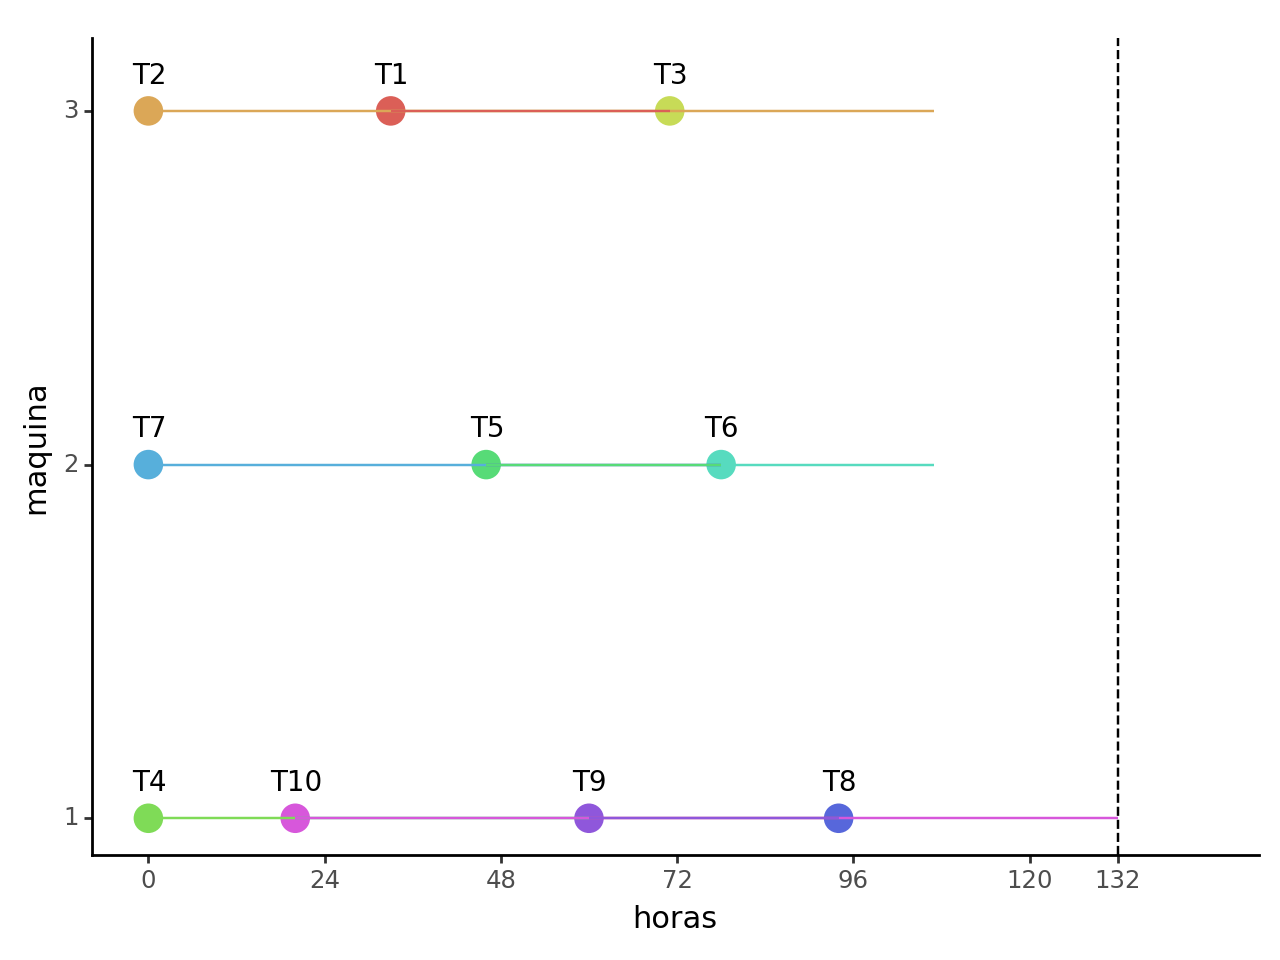

<Figure Size: (640 x 480)>

In [412]:
fromCromo(filho).horario.plot()

In [413]:
create_df(fromCromo(filho))

,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T4(20), T10(40), T9(34), T8(38)]","[T7(46), T5(32), T6(29)]","[T2(33), T1(38), T3(36)]",132,False,True


## Pergunta e)

**Operador de Mutação**

### Mutação por troca

In [414]:
def mutacao(crom, prob=.1):
    crom = crom.copy()
    # Verificar se a mutação será aplicada com base na probabilidade
    if random.random() < prob:
        # Selecionar aleatoriamente duas posições diferentes no cromossomo
        ind1 = random.randint(0, len(crom)-1)
        ind2 = random.randint(0, len(crom)-1)
        
        # Realizar a troca entre as duas posições
        crom[ind1], crom[ind2] = crom[ind2], crom[ind1]
    return crom

In [415]:
seed(1)
print(mut := mutacao(filho, prob = 1))
create_df(fromCromo(mut))

[4, 7, 9, 8, 10, 5, 6, 2, 1, 3]


,M1,M2,M3,tempo_total,respeita_restricao,respeita_unique
0,"[T4(20), T7(46), T9(34), T8(38)]","[T10(40), T5(32), T6(29)]","[T2(33), T1(38), T3(36)]",138,False,True


## Pergunta f)

TODO com texto melhor mas não pq o um cromo não é admissível se não tiver as tais 90 horas naquelas 3 tarefas especias (mas ele garante que tem tarefas unicas (as tarefas não são feitas duas vezes) e que têm todas tamanho 10 (como são unicas significa que todas as tarefas são feitas))

Pra resolver vamos por uma penalizacao na funcao de avaliação (q é o tempo_total)

In [416]:
def aptidaoFunc(perm: list[int] | Permutation, penalizacao = 20):
  if not isinstance(perm, Permutation): perm = fromCromo(cromo)
  will_be_penalized = not respeitaRestricao(perm.horario, restricao)
  return perm.horario.tempoTotal + (penalizacao if will_be_penalized else 0)

def create_df_updated(permutations: list[Permutation] | Permutation, *args):
  if isinstance(permutations, Permutation): return create_df([permutations, *args])
  return pd.DataFrame({
    "M1": [p.maquinas[0].tarefas for p in permutations],
    "M2": [p.maquinas[1].tarefas for p in permutations],
    "M3": [p.maquinas[2].tarefas for p in permutations],
    "tempo_total": [p.horario.tempoTotal for p in permutations],
    "respeita_restricao": [respeitaRestricao(p.horario, restricao) for p in permutations],
    "aptidao": [aptidaoFunc(p) for p in permutations]
  })
create_df = create_df_updated # dangerous, remove if its making problems
# exemploo
create_df([primeiro, heuristica, fromCromo(filho), fromCromo(mut)])

,M1,M2,M3,tempo_total,respeita_restricao,aptidao
0,"[T1(38), T2(33), T3(36), T4(20)]","[T5(32), T6(29), T7(46)]","[T8(38), T9(34), T10(40)]",127,False,147
1,"[T4(20), T6(29), T2(33), T9(34)]","[T3(36), T1(38), T7(46)]","[T5(32), T8(38), T10(40)]",120,True,120
2,"[T4(20), T10(40), T9(34), T8(38)]","[T7(46), T5(32), T6(29)]","[T2(33), T1(38), T3(36)]",132,False,152
3,"[T4(20), T7(46), T9(34), T8(38)]","[T10(40), T5(32), T6(29)]","[T2(33), T1(38), T3(36)]",138,False,158


# g)

In [417]:
@dc
class Cromossomo:
  crom: list[int]
  __aptidao: int = None
  __aptidao_calculada: bool = False
  def respeitaRestricao(self) -> bool:
    return respeitaRestricao(fromCromo(self.crom).horario, restricao)
  @property
  def aptidao(self) -> int:
    if not self.__aptidao_calculada:
      self.__aptidao = aptidaoFunc(fromCromo(self.crom))
      self.__aptidao_calculada = True
    return self.__aptidao
  def __getitem__(self, i):
    return self.crom[i]
  def __len__(self):
    return len(self.crom)

@dc
class Populacao:
  curr_iter: int
  cromos: list[list[int]] | list[Cromossomo]
  def __post_init__(self):
    if isinstance(self.cromos[0], Cromossomo): return
    self.cromos = [Cromossomo(c) for c in self.cromos]
  def __getitem__(self, i):
    return self.cromos[i]
  def sort(self, reverse = False):
    self.cromos.sort(key=lambda c: c.aptidao, reverse=reverse)
    return self
  def add(self, crom: Cromossomo | list[Cromossomo] | list[int] | list[list[int]]):
    if isinstance(crom, Cromossomo): self.cromos.append(crom)
    elif isinstance(crom[0], Cromossomo): self.cromos.extend(crom)
    elif isinstance(crom[0], int): self.cromos.append(Cromossomo(crom))
    elif isinstance(crom[0], list): self.cromos.extend([Cromossomo(c) for c in crom])
    else: raise TypeError
    return self

In [418]:
# gerar populacao inicial
def populacaoInicial(tamanho: int, log = False, tamanho_cromo = 10) -> list[list[int]]:
  populacao = []
  for i in range(tamanho):
    cromo = random.sample(range(1, tamanho_cromo+1), tamanho_cromo)
    if log: print(f"Cromo {i+1}: {cromo}")
    populacao.append(cromo)
  return Populacao(0, populacao)
seed(1)
populacao = populacaoInicial(10, log=True)

Cromo 1: [3, 2, 5, 1, 4, 6, 8, 10, 9, 7]
Cromo 2: [2, 8, 1, 7, 4, 6, 9, 3, 10, 5]
Cromo 3: [4, 2, 6, 1, 7, 8, 5, 9, 10, 3]
Cromo 4: [1, 9, 4, 7, 8, 6, 2, 5, 10, 3]
Cromo 5: [8, 5, 1, 4, 9, 10, 2, 3, 7, 6]
Cromo 6: [6, 9, 7, 5, 10, 2, 3, 8, 4, 1]
Cromo 7: [10, 1, 8, 2, 6, 4, 5, 3, 9, 7]
Cromo 8: [9, 6, 2, 4, 10, 5, 1, 7, 8, 3]
Cromo 9: [8, 1, 10, 9, 3, 5, 4, 6, 7, 2]
Cromo 10: [9, 4, 1, 7, 2, 5, 6, 10, 3, 8]


In [419]:
@dc
class CriteriosDeParagem:
  iter_max: int = None
  no_improv_max: int = None
  aptid_min: int = None
  def __post_init__(self):
    self.curr_iter = 0
    self.no_improv_iter = 0
    self.aptid_max = 0
  def shouldStop(self) -> bool:
    return (
      (self.iter_max is not None and self.curr_iter >= self.iter_max) or
      (self.no_improv_max is not None and self.no_improv_iter >= self.no_improv_max) or
      (self.aptid_min is not None and self.aptid_max >= self.aptid_min)
    )
  def update(self, max_aptid_found: int):
    self.curr_iter += 1
    self.no_improv_iter += 1 if max_aptid_found > self.aptid_max else 0
    self.aptid_max = max(self.aptid_max, max_aptid_found)



In [420]:
# selecao proporcional à aptidao
def selecao(populacao: Populacao) -> tuple[Cromossomo, Cromossomo]:
  # calcular a atpidao comulativa
  sumcum = list(itertools.accumulate([c.aptidao for c in populacao]))
  # escolher um numero aleatorio entre 0 e a soma da aptidao
  r = random.uniform(0, sumcum[-1])
  # encontrar o indice do primeiro elemento maior que o numero aleatorio
  ind1 = first_ind(sumcum, lambda x: x >= r)
  # 2 vezes
  r = random.uniform(0, sumcum[-1])
  ind2 = first_ind(sumcum, lambda x: x >= r)

  return populacao[ind1], populacao[ind2]
  

In [421]:
# Algoritmo Genético
def algoritmoGenetico(
  tamanho_populacao: int,
  criterios_de_paragem: CriteriosDeParagem = CriteriosDeParagem(),
  elitismo_tamanho: int = 1,
  log = False
) -> tuple[Cromossomo, list[Populacao]]:
  ret = []
  # 1. Gerar a população inicial
  populacao: Populacao = populacaoInicial(tamanho_populacao).sort(reverse=False)
  elites: list[Cromossomo] = [populacao[i] for i in range(elitismo_tamanho)]
  # 2. popular uma nova população
  while not criterios_de_paragem.shouldStop():
    if log: print(f"iteração {criterios_de_paragem.curr_iter}")
    new_populacao = Populacao(criterios_de_paragem.curr_iter + 1, [])
    for _ in range(tamanho_populacao): # modelo geracional
      # 2.1 seleção dos pais
      pai, mae = selecao(populacao)
      # 2.2 cruzamento
      filho_l = cruzamento(pai, mae)
      # 2.3. mutação
      filho_l = mutacao(filho_l)
      # 2.4. adicionar o filho à nova população
      new_populacao.append(filho := Cromossomo(filho_l))
    # 3. elitismo
    # 3.1 obter o(s) menos abto(s)
    new_populacao = sorted(new_populacao, key=lambda c: c.aptidao, reverse=False)
    # 3.2 substituir o menos apto pelo mais apto da nova populacao
    for i in range(elitismo_tamanho):
      new_populacao[i] = elites[i]
    # 3.3 atualizar os elites se necessário
    [elites.append(new_populacao[i]) for i in range(elitismo_tamanho)]
    elites = sorted(elites, key=lambda c: c.aptidao, reverse=False)[:elitismo_tamanho]

    ret.append(populacao := new_populacao)
    # 4. critérios de paragem
    criterios_de_paragem.update(elites[0].aptidao)
  return elites[0], ret

In [422]:
# exemplo
seed(1)
fromCromo(algoritmoGenetico(
  tamanho_populacao=10,
  criterios_de_paragem=CriteriosDeParagem(iter_max=10),
  elitismo_tamanho=1,
  log=True
)[0]).horario.plot()

iteração 0


IndexError: list index out of range